In [9]:
import os
os.listdir('../data')

['dataset', 'clean', 'unclean']

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from csvLoader import get_data
from Heuristics import get_labels
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

# Few common functions

In [11]:
def get_grid(rs=11):
    param_grid = {
    'max_depth': [3, 5,10,20],
    'min_samples_leaf': [5, 10,30,50,100, 150],
    'min_samples_split': [10,20,30,50,100],
    'n_estimators': [10,50,100,150,200,300],
    #[int(x) for x in np.linspace(start=2, stop=20, num=1)],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}
    rf = RandomForestClassifier(n_jobs=-1)

    grid_rf = RandomizedSearchCV(rf,
                         param_grid,
                          verbose=1,
                           n_jobs=-1,
                            cv=5,
                            n_iter=5,
                            random_state=rs)

    return grid_rf

def evaluate(rfS, X_Train, X_Test,y_Train, y_Test):
    testPreds = rfS.predict(X_Test)
    trainPreds = rfS.predict(X_Train)
    
    classReportTest = classification_report(y_Test,testPreds, output_dict=True, target_names= ["face", "non-face"])
    classReportTrain = classification_report(y_Train,trainPreds, output_dict=True, target_names= ["face", "non-face"])
    
    return classReportTest,classReportTrain
    

def _filter_cols( type=[["ag"],["nr"]]):
    filterCols = list()

    cols = get_labels()    
    abbrev = {"a":"accel","g":"gyro", "r":"r", "n":"n"}
    typeCriteria = [[abbrev[tC] for tC in list(t[0])] for t in type]

    # check and add resultant first
    for sensor in typeCriteria[0]:
        for axis in typeCriteria[1]:
            if axis == "r":
                filterCols.extend([c for c in cols if sensor in c.split("_") and axis in c.split("_")])
            else:
                filterCols.extend([c for c in cols if sensor in c.split("_") and "r" not in c.split("_")])
    return filterCols

def get_train_test_data(csvCode = "50_8", type=[["ag"],["rn"]]):

    csvPATH =   "../data/dataset/statFeatures/stat{}.csv".format(csvCode)
    data = get_data(PATH=csvPATH)
    features, pids, descriptions, labels = data.features, data.pids, data.descriptions, data.labels
    
    cols = get_labels()
    features = pd.DataFrame(features,columns=cols)
    filterCols = _filter_cols(type=type)
    features = features[filterCols]
    #features = features[filterCols]

    X_Train, X_Test, y_Train, y_Test = train_test_split(features.values,
                                    np.array(list(zip(pids,descriptions,labels))),
                                    test_size=0.2,
                                    shuffle=True,
                                    random_state=111)

    return filterCols, X_Train, X_Test, y_Train, y_Test

def get_rcParams(plt):
    plt.rcParams['font.size'] = 12
    plt.rcParams['hatch.linewidth'] = 0.25
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'
    plt.rcParams['figure.dpi'] = 600
    plt.rcParams["lines.linewidth"] = 1
    plt.rcParams['hatch.linewidth'] = 0.15
    return plt

In [12]:
a,b,c,d,e = get_train_test_data(csvCode="20_8", type=[["ag"],["rn"]])

############################################################
../data/dataset/statFeatures/stat20_8.csv
Data loaded from ../data/dataset/statFeatures/stat20_8.csv


In [13]:
colNames, Xb_Train, X_Test, y_Train,y_Test = get_train_test_data(csvCode="80_8", type = [["ag"],["nr"]])

############################################################
../data/dataset/statFeatures/stat80_8.csv
Data loaded from ../data/dataset/statFeatures/stat80_8.csv


# Confusion Matrix

[[356  49]
 [ 60 390]]


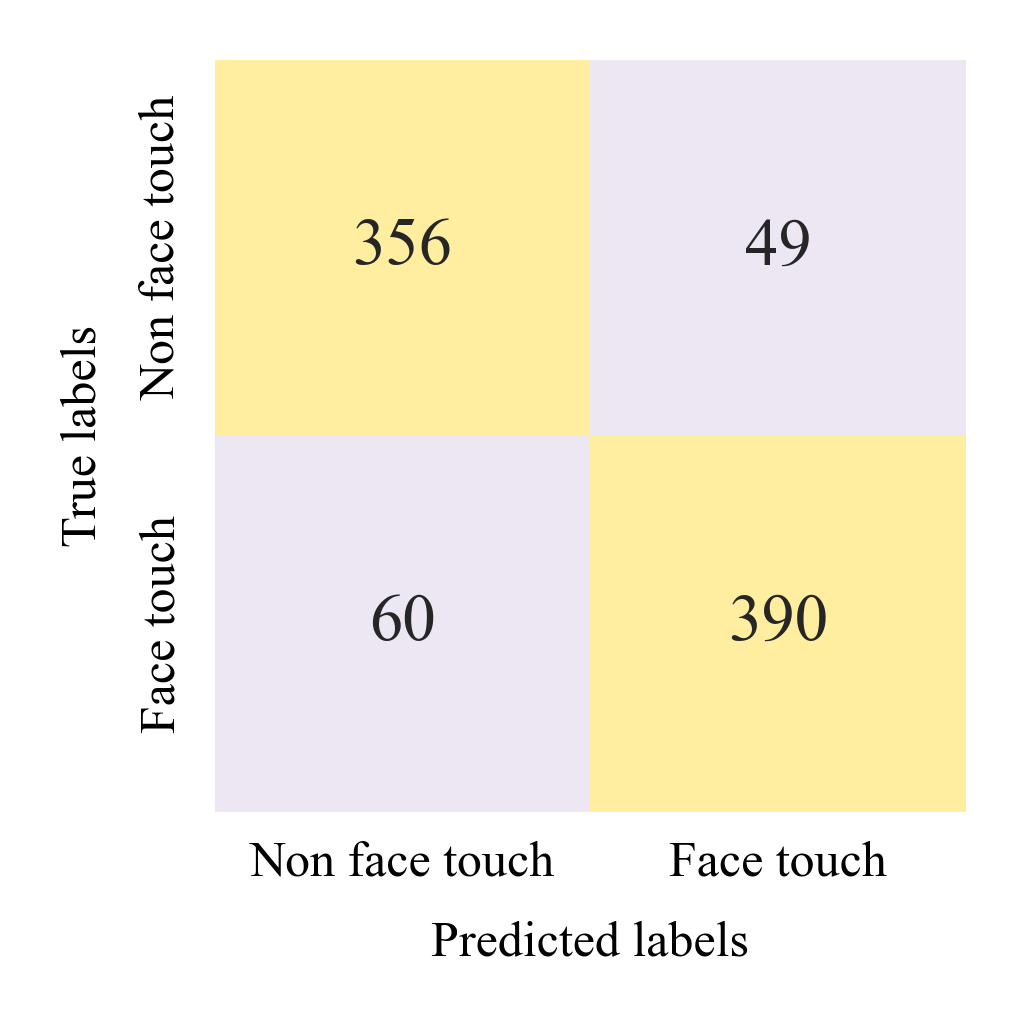

In [315]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
fontsize = 6
plt.figure(figsize=(1.75,1.75), dpi =600)

plt.rcParams['font.size'] = fontsize+2

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
# plt.rcParams['figure.dpi'] = 1000

plt.rcParams["lines.linewidth"] = 0.75

mode = "train"


#Get the confusion matrix
if mode =="train":
    cf_matrix = confusion_matrix(y_Testl, rBP.predict(X_TestPoly[::,first340]))

else:
    print("f")
    #cf_matrix = confusion_matrix(y_Test, clf.predict(X_Test))

print(cf_matrix)

ax = plt.subplot()

group_names = ["True Negative (TN)","False Positive (FP)","False Negative (FN)","True Positive (TP)"]

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
#["#ffffbf","#fc8d59","#91bfdb"]
labels = np.array(group_counts).reshape(2,2)
hmap = sns.heatmap(cf_matrix, annot=labels, fmt='', cbar=False,cmap = ["#ece7f2","tab:red","#ffeda0"])

ax.set_yticklabels(["Non face touch", "Face touch"], verticalalignment = 'center', size=fontsize)
ax.set_xticklabels(["Non face touch", "Face touch"], horizontalalignment = 'center', size=fontsize)
ax.set_ylabel("True labels", size=fontsize)
ax.set_xlabel("Predicted labels", size=fontsize)
ax.tick_params(axis=u'both', which=u'both',length=0)

# if mode =="train":
#     ax.set_title("Train-split", size=fontsize)

# else:
#     ax.set_title("Test-split", size=fontsize)

plt.tight_layout()

# if mode =="train":
#     plt.savefig("results/rfconfTest.png")
# else:
#     plt.savefig("results/rfconfTrain.png")
plt.savefig("confMatimp.png")

In [314]:
(354+401)/(354+401+100)

0.8830409356725146

In [297]:
%pip install seaborn

     |████████████████████████████████| 292 kB 3.0 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [72]:
np.take(y_Train,2,axis=-1)

array(['1', '1', '0', ..., '1', '1', '1'], dtype='<U7')

# What is the effect of window size on non-polynomial features ?

In [68]:
testAccuracies = list()
trainAccuracies = list()
cvResults = list()
for csvCode in ["20_8","30_8","40_8","50_8","60_8","70_8","80_8"]:
    
    colNames, X_Train, X_Test, y_Train,y_Test = get_train_test_data(csvCode=csvCode, type = [["ag"],["nr"]])
    y_Trainl = np.take(y_Train,2,axis=-1)
    y_Testl = np.take(y_Test,2,axis=-1)

    grid_rf = get_grid()    
    
    #cvResult = cross_validate(rf, features, labels,cv=5)
    #cvResults.append(cvResult)
    grid_rf.fit(X_Train, y_Trainl)
    rfBest = grid_rf.best_estimator_

    classReportTest,classReportTrain =evaluate(rfBest, X_Train,X_Test, y_Trainl, y_Testl)

    testAccuracies.append(classReportTest["accuracy"])
    trainAccuracies.append(classReportTrain["accuracy"])

############################################################
../data/dataset/statFeatures/stat20_8.csv
Data loaded from ../data/dataset/statFeatures/stat20_8.csv
Fitting 3 folds for each of 300 candidates, totalling 900 fits
############################################################
../data/dataset/statFeatures/stat30_8.csv
Data loaded from ../data/dataset/statFeatures/stat30_8.csv
Fitting 3 folds for each of 300 candidates, totalling 900 fits
############################################################
../data/dataset/statFeatures/stat40_8.csv
Data loaded from ../data/dataset/statFeatures/stat40_8.csv
Fitting 3 folds for each of 300 candidates, totalling 900 fits
############################################################
../data/dataset/statFeatures/stat50_8.csv
Data loaded from ../data/dataset/statFeatures/stat50_8.csv
Fitting 3 folds for each of 300 candidates, totalling 900 fits
############################################################
../data/dataset/statFeatures/stat60_8.c

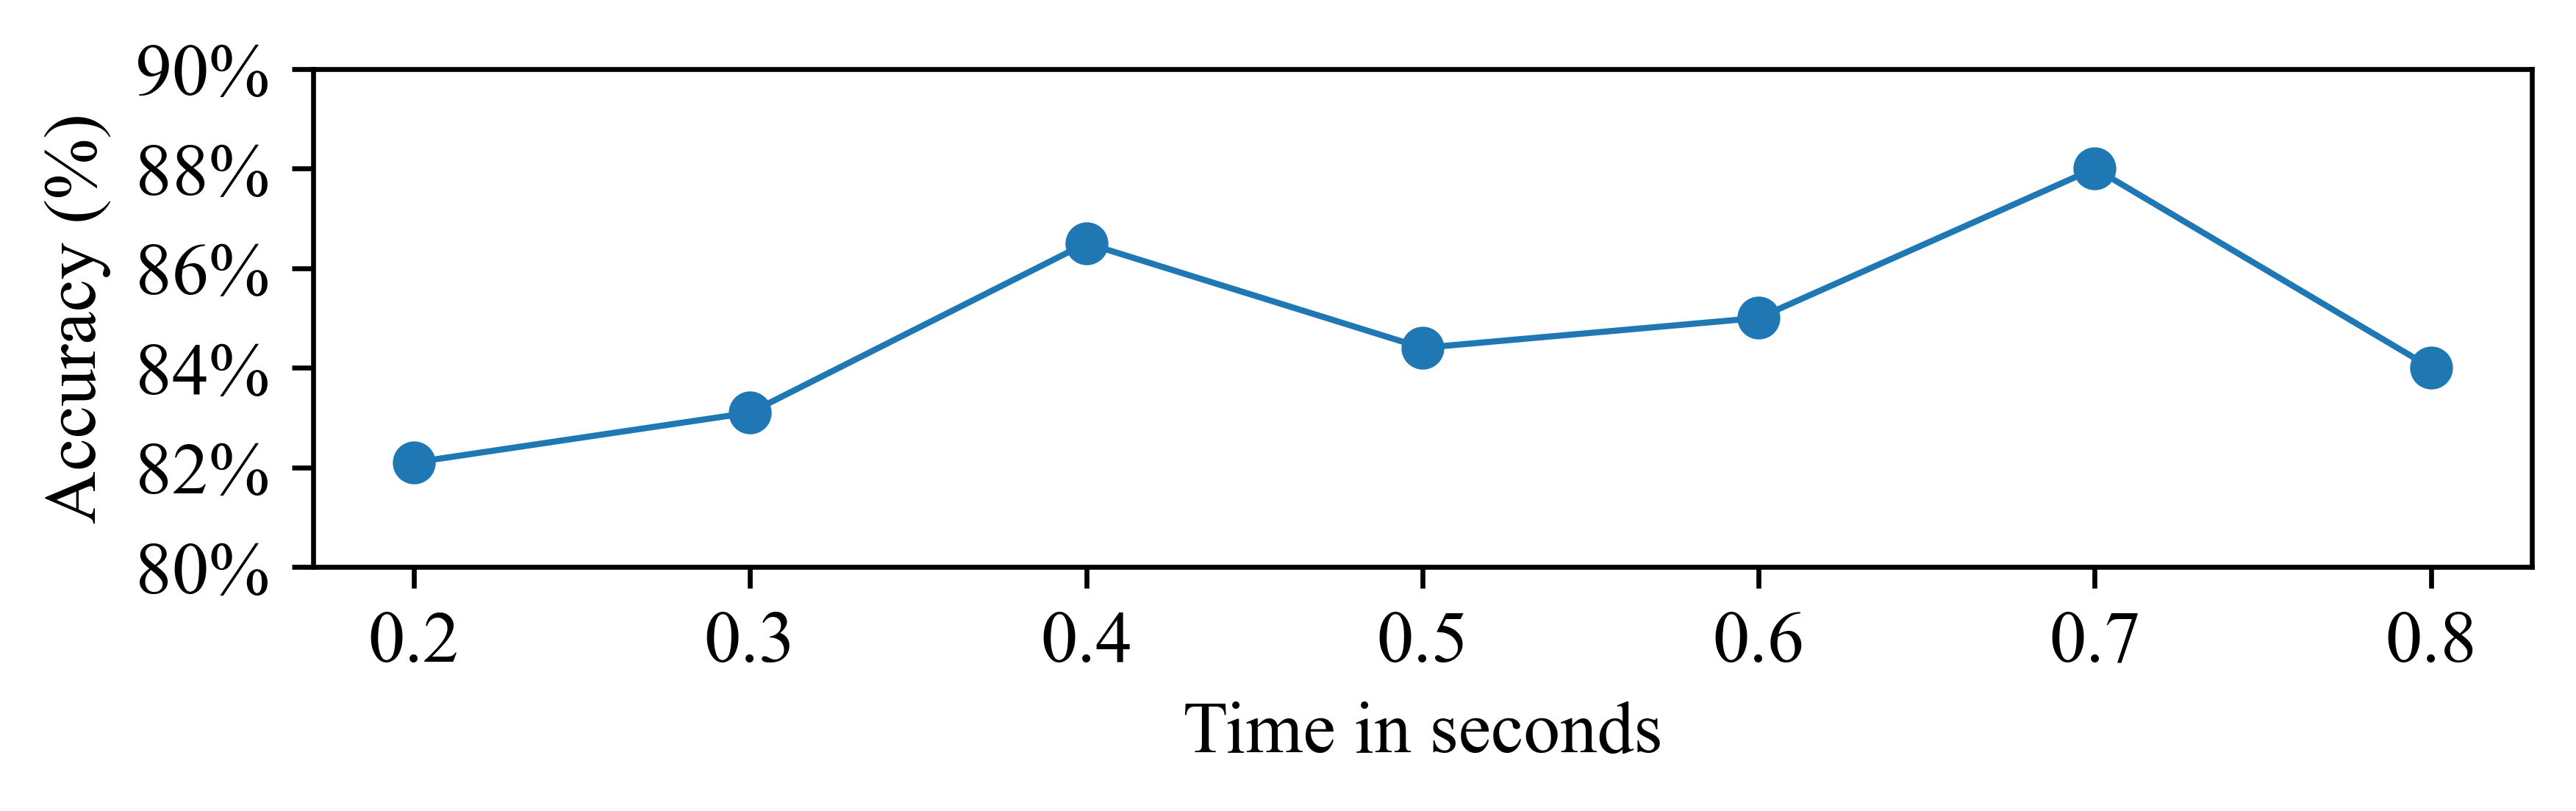

In [149]:
#fig, axs = plt.subplots(1,2, figsize = (4,2), dpi = 600)
plt= get_rcParams(plt)
plt.figure(figsize=(6,2))
x = ["0.2", "0.3", "0.4", "0.5", "0.6","0.7","0.8"]
testAccuracies = [0.821,0.831,0.865, 0.844, 0.850,0.88, 0.8 ]
plt.plot(x,np.array(testAccuracies)*100, color = "tab:blue")
plt.scatter(x,np.array(testAccuracies)*100)

#plt.plot(x,testAccuracies, label="test")
plt.xlabel("Time in seconds")
plt.ylabel("Accuracy (%)")
plt.yticks([80,82,84,86,88,90],labels=["80%","82%","84%","86%","88%","90%"])
#plt.plot(x,trainAccuracies, label = "train")
#plt.legend()
plt.tight_layout()
plt.savefig("windowSelect.png")

# What is the effect of accel, gyro, accel+gyro all combinations when window is fixed?

In [45]:
testAccuracies = list()
trainAccuracies = list()
cvResults = list()
for type in [   [["ag"],["nr"]],
                [["ag"],["n"]],
                [["ag"],["r"]],
                [["a"],["nr"]],
                [["a"],["n"]],
                [["a"],["r"]],
                [["g"],["nr"]],
                [["g"],["n"]],
                [["g"],["r"]] ]:
    
    colNames, X_Train, X_Test, y_Train,y_Test = get_train_test_data(csvCode= "40_8", type = type)
    y_Trainl = np.take(y_Train,2,axis=-1)
    y_Testl = np.take(y_Test,2,axis=-1)

    grid_rfNP = get_grid()    
    
    grid_rf.fit(X_Train, y_Trainl)
    rfBestNP = grid_rf.best_estimator_

    classReportTest,classReportTrain = evaluate(rfBest, X_Train,X_Test, y_Trainl, y_Testl)

    testAccuracies.append(classReportTest["accuracy"])
    trainAccuracies.append(classReportTrain["accuracy"])

############################################################
../data/dataset/statFeatures/stat40_8.csv
Data loaded from ../data/dataset/statFeatures/stat40_8.csv
Fitting 3 folds for each of 300 candidates, totalling 900 fits
############################################################
../data/dataset/statFeatures/stat40_8.csv
Data loaded from ../data/dataset/statFeatures/stat40_8.csv
Fitting 3 folds for each of 300 candidates, totalling 900 fits
############################################################
../data/dataset/statFeatures/stat40_8.csv
Data loaded from ../data/dataset/statFeatures/stat40_8.csv
Fitting 3 folds for each of 300 candidates, totalling 900 fits
############################################################
../data/dataset/statFeatures/stat40_8.csv
Data loaded from ../data/dataset/statFeatures/stat40_8.csv
Fitting 3 folds for each of 300 candidates, totalling 900 fits
############################################################
../data/dataset/statFeatures/stat40_8.c

In [48]:
testAccuracies

[0.8771929824561403,
 0.8865497076023392,
 0.808187134502924,
 0.8654970760233918,
 0.8292397660818713,
 0.6467836257309941,
 0.7812865497076024,
 0.8093567251461988,
 0.7380116959064328]

# Non-polynomial top-10 features

In [79]:
colNames, X_Train, X_Test, y_Train,y_Test = get_train_test_data(csvCode= "40_8", type = [["ag"],["n"]])
y_Trainl = np.take(y_Train,2,axis=-1)
y_Testl = np.take(y_Test,2,axis=-1)

grid_rfNP = get_grid()    

grid_rf.fit(X_Train, y_Trainl)
rfBestNP = grid_rf.best_estimator_

# cols = get_labels()

# impDataSelect = np.array(list(zip(rfBestNorm.feature_importances_, cols)))
# impDfSelect = pd.DataFrame(impDataSelect, columns = ["val","feat"]).sort_values(by="val", ascending=False)
# impDfSelect10 = impDfSelect.sort_values(by="val", ascending=False)[:10]

# rfBest.fit(X_Train[::,list(impDfSelect10.index)], y_Train)
# testPreds = rfBest.predict(X_TestPoly[::,list(impDfSelect10.index)])
# trainPreds = rfBest.predict(X_TrainPoly[::,list(impDfSelect10.index)])
# print(classification_report(y_Test, testPreds))
# print("Test accuracy for top 10 poly features is {} ".format(accuracy_score(y_Test, testPreds)*100))
# print("Train accuracy for top 10 poly features is {} ".format(accuracy_score(y_Train, trainPreds)*100))

############################################################
../data/dataset/statFeatures/stat40_8.csv
Data loaded from ../data/dataset/statFeatures/stat40_8.csv
Fitting 3 folds for each of 300 candidates, totalling 900 fits


(3416, 1540)

# Polynomial Features

In [16]:
colNames, X_Train, X_Test, y_Train,y_Test = get_train_test_data(csvCode= "40_8", type = [["ag"],["n"]])

y_Trainl = np.take(y_Train,2,axis=-1)
y_Testl = np.take(y_Test,2,axis=-1)

poly = PolynomialFeatures(degree=2)
poly.fit(X_Train)

X_TrainPoly= poly.transform(X_Train)
X_TestPoly = poly.transform(X_Test)

for i in [11]:
    grid_rf = get_grid(rs=i)    
    grid_rf.fit(X_TrainPoly, y_Trainl)
    rfBestPoly = grid_rf.best_estimator_
    print(rfBestPoly.score(X_TestPoly,y_Testl),rfBestPoly.score(X_TrainPoly,y_Trainl))
    if rfBestPoly.score(X_TestPoly,y_Testl)>0.9:
        break

############################################################
../data/dataset/statFeatures/stat40_8.csv
Data loaded from ../data/dataset/statFeatures/stat40_8.csv
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.8771929824561403 0.9590163934426229


In [17]:
i

11

In [137]:
from sklearn.base import clone
rBP= clone(rfBestPoly)

In [139]:
rBP.set_params(max_depth=10)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=10, n_estimators=150, n_jobs=-1)

In [318]:
from sklearn.metrics import precision_recall_fscore_support

In [323]:
np.mean(precision_recall_fscore_support(y_Testl, rfBestPoly.predict(X_TestPoly)),axis=1)

array([  0.88279003,   0.88259259,   0.88268644, 427.5       ])

In [105]:
X_TrainPoly.shape

(3416, 1540)

In [110]:
from collections import Counter

In [142]:
import tqdm
scores = list()
featuresInFocus = list()
cols = get_labels()

impDataSelect = np.array(list(zip(rfBestPoly.feature_importances_, 
                        poly.get_feature_names(cols))))

impDfSelect = pd.DataFrame(impDataSelect, columns = ["val","feat"]).sort_values(by="val", ascending=False)

impDfSelect10 = impDfSelect.sort_values(by="val", ascending=False)[:10]
totalSpace = list(np.array(impDfSelect.index[:1540]).reshape(154,10))
#totalSpace.append(impDfSelect.index[3410:3416])

for selectItems in tqdm.tqdm(totalSpace):
    featuresInFocus.extend(selectItems)
    rBP.fit(X_TrainPoly[::,featuresInFocus],y_Trainl)
    scores.append(accuracy_score(y_Testl, rBP.predict(X_TestPoly[::,featuresInFocus])))

100%|██████████| 154/154 [01:34<00:00,  1.63it/s]


In [290]:
first340 = list(impDfSelect.index[:340])
rBP.fit(X_TrainPoly[::,first340],y_Trainl)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=10, n_estimators=150, n_jobs=-1)

In [291]:
rBP.score(X_TrainPoly[::,first340], y_Trainl)

0.9332552693208431

In [293]:
rBP.score(X_TestPoly[::,first340], y_Testl)

0.8725146198830409

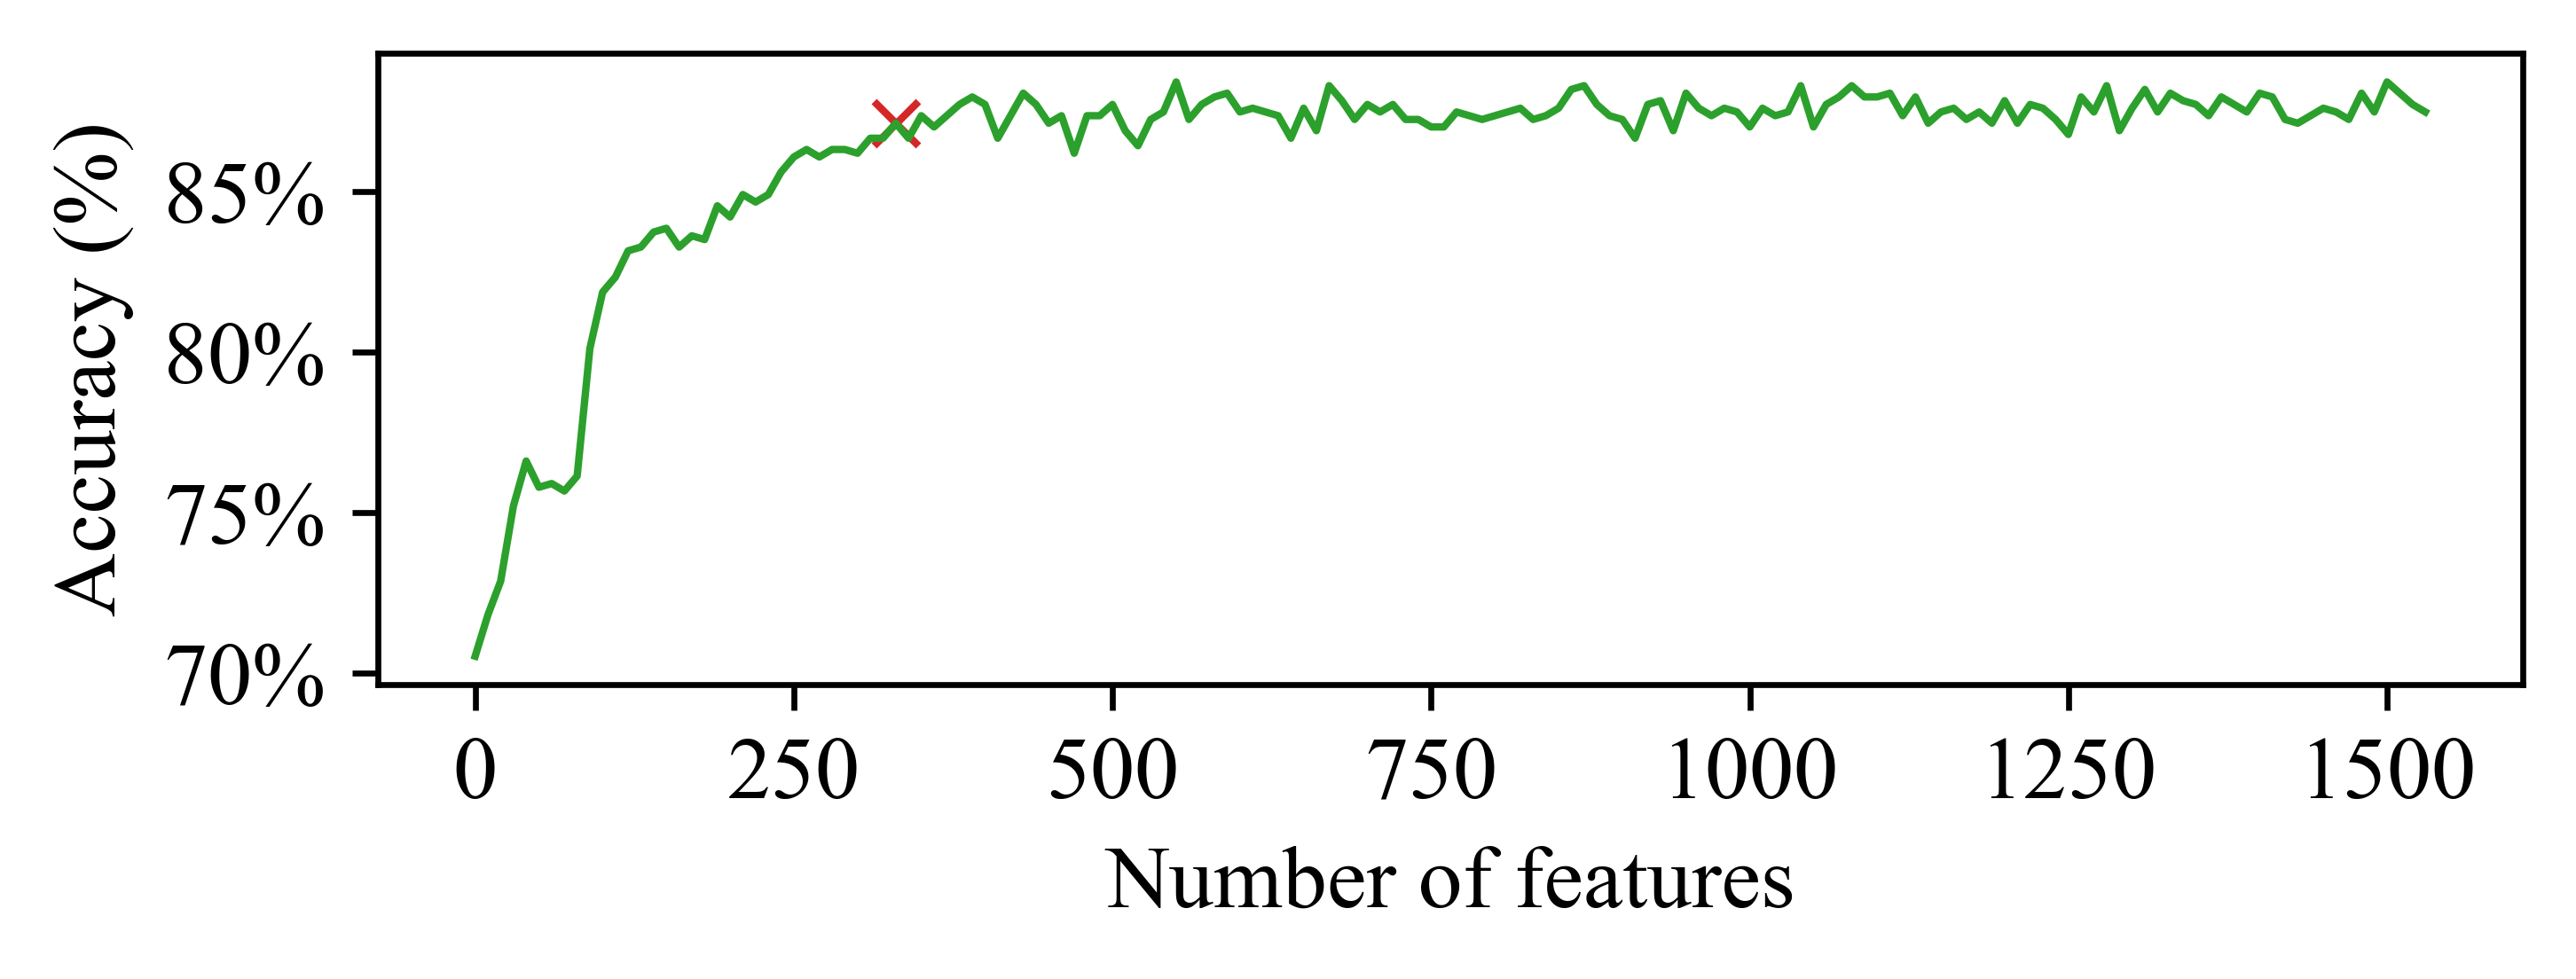

In [266]:
plt = get_rcParams(plt)
plt.figure(figsize=(5,2))
ax = plt.subplot()
ax.plot(np.linspace(0,1540,155)[:154],np.array(scores)*100, color = "tab:green")
ax.scatter([330],np.array(scores[33])*100, color = "tab:red", marker="x")
#ax.set_xticklabels(["0","250","500","750","1000","1250","1500"])
ax.set_yticks([70,75,80,85])
ax.set_yticklabels(["70%","75%","80%","85%"])
ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy (%)")
plt.tight_layout()
plt.savefig("featSelect.png")

In [272]:
Counter(y_Trainl)#+Counter(y_Testl)

Counter({'0': 1675, '1': 1741})

In [274]:
1675+1741

3416

In [278]:
rfBestPoly.score(X_TestPoly,y_Testl)

0.8830409356725146

In [280]:
rBP.score(X_TestPoly[],y_Testl)

ValueError: X has 1540 features, but DecisionTreeClassifier is expecting 330 features as input.

In [271]:
Counter(y_Testl)

Counter({'1': 450, '0': 405})

In [219]:
rfMin = RandomForestClassifier()

In [ ]:
print("Test accuracy for non-poly features is {} ".format(accuracy_score(y_Test, testPreds)*100))
print("Train accuracy for non-poly features is {} ".format(accuracy_score(y_Train, trainPreds)*100))

In [ ]:
rfBest = grid_rf.best_estimator_
rfBest.fit(X_Train[::,list(impDfSelect10.index)], y_Train)
testPreds = rfBest.predict(X_TestPoly[::,list(impDfSelect10.index)])
trainPreds = rfBest.predict(X_TrainPoly[::,list(impDfSelect10.index)])
print(classification_report(y_Test, testPreds))
print("Test accuracy for top 10 poly features is {} ".format(accuracy_score(y_Test, testPreds)*100))
print("Train accuracy for top 10 poly features is {} ".format(accuracy_score(y_Train, trainPreds)*100))

In [ ]:
cols = get_labels()
impDataSelect = np.array(list(zip(rfBestNorm.feature_importances_, cols)))
impDfSelect = pd.DataFrame(impDataSelect, columns = ["val","feat"]).sort_values(by="val", ascending=False)
impDfSelect10 = impDfSelect.sort_values(by="val", ascending=False)[:10]

In [ ]:
rfBestNorm.fit(X_Train[::,impDfSelect10.index],y_Train)
testPreds = rfBestNorm.predict(X_Test[::,list(impDfSelect10.index)])
trainPreds = rfBestNorm.predict(X_Train[::,list(impDfSelect10.index)])

print("Test accuracy for top 10 non-poly features is {} ".format(accuracy_score(y_Test, testPreds)*100))
print("Train accuracy for top 10 non-poly features is {} ".format(accuracy_score(y_Train, trainPreds)*100))

In [ ]:
scores = list()
for selectItems in np.array(impDfSelectNorm.index).reshape(11,8):
    rfNorm.fit(X_Train[::,selectItems],y_Train)
    scores.append(accuracy_score(y_Test, rfNorm.predict(X_Test[::,selectItems])))

In [ ]:
[np.mean(r["train_score"]) for r in cvResults]

In [ ]:


#fig, axs = plt.subplots(1,2, figsize = (4,2), dpi = 600)

x = ["0.2", "0.3", "0.4", "0.5", "0.6","0.7"]
plt.plot(x,np.array(testAccuracies)*100, color = "tab:blue")
plt.scatter(x,np.array(testAccuracies)*100)

#plt.plot(x,testAccuracies, label="test")
plt.xlabel("Time in seconds")
plt.ylabel("Accuracy (%)")
plt.yticks([80,82,84,86,88,90],labels=["80%","82%","84%","86%","88%","90%"])
#plt.plot(x,trainAccuracies, label = "train")
#plt.legend()
plt.savefig("windowSelect.png")

In [ ]:
poly  = PolynomialFeatures(2)
poly = poly.fit(X_Train)

X_TrainPoly = poly.transform(X_Train)
X_TestPoly = poly.transform(X_Test)

rf = RandomForestClassifier(n_jobs=-1, verbose=0)
param_grid = {
    'max_depth': [3, 5,10,20],
    'min_samples_leaf': [5, 10,30,50,100, 150],
    'min_samples_split': [10,20,30,50,100],
    'n_estimators': [10,50,100,150,200,300],
    #[int(x) for x in np.linspace(start=2, stop=20, num=1)],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# param_grid['pca__n_components'] = hyper['pca__n_components']
#pipe = Pipeline([('poly',poly), ('rf', rf)])

grid_rf = RandomizedSearchCV(rf,
                         param_grid,
                          verbose=1,
                           n_jobs=-1,
                            cv=3,
                            n_iter=30)
grid_rf.fit(X_TrainPoly, y_Train)
print(grid_rf.best_params_)

In [ ]:
rfBest = grid_rf.best_estimator_
rfBest.fit(X_TrainPoly,y_Train)
testPreds = rfBest.predict(X_TestPoly)
print(classification_report(y_Test, testPreds))
print("Test accuracy for poly features is {} ".format(accuracy_score(y_Test, testPreds)*100))
print("Train accuracy for poly features is {} ".format(accuracy_score(y_Train, rfBest.predict(X_TrainPoly))*100))

In [ ]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rfBest, X_TestPoly, y_Test)
#plot_roc_curve(rfBestNorm,X_Test,y_Test)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("rocnonpoly.png")

In [89]:
cols = get_labels()
impDataSelect = np.array(list(zip(rfBest.feature_importances_, 
                        poly.get_feature_names(cols))))

impDfSelect = pd.DataFrame(impDataSelect, columns = ["val","feat"]).sort_values(by="val", ascending=False)

impDfSelect10 = impDfSelect.sort_values(by="val", ascending=False)[:10]

# What is the accuracy when rf is fit with top 10 polynomial features

In [93]:
rfBest = grid_rf.best_estimator_
rfBest.fit(X_TrainPoly[::,list(impDfSelect10.index)], y_Trainl)
testPreds = rfBest.predict(X_TestPoly[::,list(impDfSelect10.index)])
trainPreds = rfBest.predict(X_TrainPoly[::,list(impDfSelect10.index)])
print(classification_report(y_Testl, testPreds))
print("Test accuracy for top 10 poly features is {} ".format(accuracy_score(y_Testl, testPreds)*100))
print("Train accuracy for top 10 poly features is {} ".format(accuracy_score(y_Trainl, trainPreds)*100))

              precision    recall  f1-score   support

           0       0.60      0.64      0.62       408
           1       0.65      0.61      0.63       447

    accuracy                           0.63       855
   macro avg       0.63      0.63      0.63       855
weighted avg       0.63      0.63      0.63       855

Test accuracy for top 10 poly features is 62.57309941520468 
Train accuracy for top 10 poly features is 88.90515222482436 


In [123]:
rfBestPoly = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=5,  min_samples_split=20, n_estimators=150, n_jobs = -1)
rfBestPoly.fit(X_TrainPoly,y_Trainl)


RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=5,
                       min_samples_split=20, n_estimators=150, n_jobs=-1)

In [124]:
rfBestPoly.score(X_TestPoly,y_Testl)

0.5134502923976608

In [118]:
import tqdm
scores = list()
featuresInFocus = list()
cols = get_labels()

impDataSelect = np.array(list(zip(rfBestPoly.feature_importances_, 
                        poly.get_feature_names(cols))))

impDfSelect = pd.DataFrame(impDataSelect, columns = ["val","feat"]).sort_values(by="val", ascending=False)

impDfSelect10 = impDfSelect.sort_values(by="val", ascending=False)[:10]
totalSpace = list(np.array(impDfSelect.index[:1540]).reshape(154,10))
#totalSpace.append(impDfSelect.index[3410:3416])

for selectItems in tqdm.tqdm(totalSpace):
    featuresInFocus.extend(selectItems)
    rfBestPoly.fit(X_TrainPoly[::,featuresInFocus],y_Train)
    scores.append(accuracy_score(y_Test, rf.predict(X_TestPoly[::,featuresInFocus])))

  0%|          | 0/154 [00:00<?, ?it/s]


NameError: name 'rf' is not defined

In [ ]:
plt.rcParams['font.size'] = 12

plt.rcParams['hatch.linewidth'] = 0.25

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 600
plt.rcParams["lines.linewidth"] = 1
plt.rcParams['hatch.linewidth'] = 0.15

#fig, axs = plt.subplots(1,2, figsize = (4,2), dpi = 600)

#x = ["0.2", "0.3", "0.4", "0.5", "0.6","0.7"]
cFeats = list(np.linspace(10,4000,400))
cFeats.append(4005)

ax = plt.subplot()
ax.plot(cFeats[0:], (np.array(scores)*100)[0:], color = "tab:blue")
#plt.scatter(cFeats,np.array(scores)*100)

#plt.plot(x,testAccuracies, label="test")
ax.set_xlabel("Features used")
ax.set_ylabel("Accuracy (%)")
#yl = [86,87,88,89,90,91,92]
#plt.yticks(yl,labels=[str(l) + "%" for l in yl])
#plt.plot(x,trainAccuracies, label = "train")
#plt.legend()
#ax.set_ylabel(ax.yaxis.majorTicks)
def format_func(value,ticknumber):
    return str(value) + "%"

ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

plt.savefig("selectPoly10.png")

In [ ]:
ax.yaxis.majorTicks[0].__dict__.keys()


In [ ]:
rfSmall = RandomForestClassifier(max_depth = 10, n_estimators = 200)
rfSmall.fit(X_TrainPoly[::,impDfSelect10.index],y_Train)

In [ ]:
rfSmall.score(X_TestPoly[::,impDfSelect10.index],y_Test)

In [ ]:
# rf = RandomForestClassifier(n_estimators= 100, 
#                             min_samples_split= 10,
#                              min_samples_leaf= 5, 
#                              max_features= 'auto',
#                               max_depth= 10, 
#                               bootstrap= False)
# rf.fit(X_TrainPoly, y_Train)

In [ ]:
plt.rcParams['font.size'] = 12

plt.rcParams['hatch.linewidth'] = 0.25

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 600
plt.rcParams["lines.linewidth"] = 1
plt.rcParams['hatch.linewidth'] = 0.15
# plt.rcParams.update({'font.size': 20})
plt.figure(figsize= (7.0,3))

ax = plt.subplot()
ax.barh(impDfSelect["feat"].values,impDfSelect["val"].values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.tight_layout()
plt.savefig("rfImportancePoly.png")

In [ ]:
scores = list()
featuresInFocus = list()
for selectItems in np.array(impDfSelect.index).reshape(4005,100):
    featuresInFocus.extend(selectItems)
    rf.fit(X_TrainPoly[::,featuresInFocus],y_Train)
    scores.append(accuracy_score(y_Test, rf.predict(X_TestPoly[::,featuresInFocus])))

In [ ]:
rfNorm = RandomForestClassifier(n_estimators= 100, 
                            min_samples_split= 10,
                             min_samples_leaf= 5, 
                             max_features= 'auto',
                              max_depth= 10, 
                              bootstrap= False)

In [ ]:
rfNorm.fit(X_Train, y_Train)

In [ ]:
print(classification_report(rf.predict(X_Test), y_Test))

In [ ]:
impData = np.array(list(zip(rfNorm.feature_importances_, cols)))
impDfNorm = pd.DataFrame(impData, columns = ["val","feat"])
#impDfSelectNorm= impDfNorm.sort_values(by="val", ascending=False)[:10]
impDfSelectNorm= impDfNorm.sort_values(by="val", ascending=False)

In [ ]:
scores = list()
for selectItems in np.array(impDfSelectNorm.index).reshape(11,8):
    rfNorm.fit(X_Train[::,selectItems],y_Train)
    scores.append(accuracy_score(y_Test, rfNorm.predict(X_Test[::,selectItems])))

In [ ]:
plt.plot(scores)

In [ ]:
ax = plt.subplot()
ax.barh(impDfSelect["feat"].values,impDfSelect["val"].values)
#.xticks(FormatStrFormatter('%.2f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

In [ ]:
pipe['poly'].get_feature_names(cols)

In [ ]:
from Heuristics import get_labels

In [ ]:
cols = get_labels()

In [ ]:
from sklearn.decomposition import PCA


for i in range(len(features)):
    pca = PCA(n_components=2)
    pca.

# Final Classifier

In [26]:
# Load data and columns names for train-test data. (total features  = 54)
colNames, Xb_Train, X_Test, y_Train,y_Test = get_train_test_data(csvCode="40_8", type = [["ag"],["n"]])
# use random seed = 11
grid_rf = get_grid(rs=11)    
# do a grid search
grid_rf.fit(X_TrainPoly, y_Trainl)
# get best clf
rfBestPoly = grid_rf.best_estimator_

# Generate polynomial features
poly = PolynomialFeatures(degree=2)

# transform train and test features (total polynomial features = 1540)
X_TrainPoly = poly.fit_transform(X_Train)
X_TestPoly = poly.fit_transform(X_Train)

############################################################
../data/dataset/statFeatures/stat40_8.csv
Data loaded from ../data/dataset/statFeatures/stat40_8.csv
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [27]:
len(colNames)

54

In [24]:
scores = list()
featuresInFocus = list()
cols = get_labels()

impDataSelect = np.array(list(zip(rfBestPoly.feature_importances_, 
                        poly.get_feature_names(cols))))

impDfSelect = pd.DataFrame(impDataSelect, columns = ["val","feat"]).sort_values(by="val", ascending=False)

impDfSelect10 = impDfSelect.sort_values(by="val", ascending=False)[:10]
totalSpace = list(np.array(impDfSelect.index[:1540]).reshape(154,10))
#totalSpace.append(impDfSelect.index[3410:3416])

for selectItems in tqdm.tqdm(totalSpace):
    featuresInFocus.extend(selectItems)
    rBP.fit(X_TrainPoly[::,featuresInFocus],y_Trainl)
    scores.append(accuracy_score(y_Testl, rBP.predict(X_TestPoly[::,featuresInFocus])))

  0%|          | 0/154 [00:00<?, ?it/s]


NameError: name 'rBP' is not defined